In [0]:
# !ln -s /usr/lib/x86_64-linux-gnu/libcublas.so.8.0 /usr/lib/x86_64-linux-gnu/libcublas.so
# !pip install paddlepaddle-gpu==0.14.0.post85
# !ldconfig

In [0]:
import numpy as np
import paddle.fluid as fluid
import paddle
import matplotlib.pyplot as plt

## Generator &  Discriminator

In [0]:
# 噪声维度
z_dim = 100

In [0]:
# 生成器 Generator
# z.shape == (N, C, 1, 1)
def G(z, name="G"):
   
    with fluid.unique_name.guard(name + "/"):
        y = z
        
        y = fluid.layers.fc(y, size=1024, act='tanh')
        y = fluid.layers.fc(y, size=128 * 7 * 7)
        y = fluid.layers.batch_norm(y, act='tanh')
        y = fluid.layers.reshape(y, shape=(-1, 128, 7, 7))

        y = fluid.layers.image_resize(y, scale=2)
        y = fluid.layers.conv2d(y, num_filters=64, filter_size=5, padding=2, act='tanh')

        y = fluid.layers.image_resize(y, scale=2)
        y = fluid.layers.conv2d(y, num_filters=1, filter_size=5, padding=2, act='tanh')

    return y

In [0]:
# 判别器 Discriminator
def D(images, name="D"):
  
    ## 参数初始化：stddev为0.02
    param_attr = fluid.ParamAttr(initializer=fluid.initializer.Normal(scale=0.02))
    bias_attr = fluid.ParamAttr(initializer=fluid.initializer.Constant(0.0))
    
    def conv(input, num_filters, filter_size):
        y = fluid.layers.conv2d(
            input,
            num_filters=num_filters, 
            filter_size=filter_size,
            padding=0,
            stride=1,
            param_attr=param_attr,
            bias_attr=bias_attr)
        y = fluid.layers.layer_norm(y, param_attr=param_attr)
        y = fluid.layers.leaky_relu(y, 0.2)
        return y
      
    
    with fluid.unique_name.guard(name + "/"):
        y = images
        
        y = conv(y, num_filters=32, filter_size=3)
        y = fluid.layers.pool2d(y, pool_size=2, pool_stride=2)
        
        y = conv(y, num_filters=64, filter_size=3)
        y = fluid.layers.pool2d(y, pool_size=2, pool_stride=2)
        
        y = conv(y, num_filters=128, filter_size=3)
        y = fluid.layers.pool2d(y, pool_size=2, pool_stride=2)
        
        # Linear output
        y = fluid.layers.fc(y, size=1, param_attr=param_attr, bias_attr=bias_attr)

    return y

## Programs

In [0]:
# 三个训练Program
# train_d_fake、train_d_real训练D，可合成一个
train_d_fake = fluid.Program()
train_d_real = fluid.Program()

# train_g训练G
train_g = fluid.Program()

# 共享的初始化Program
startup = fluid.Program()

In [0]:
## 从program获取prefix开头的参数名字
def get_params(program, prefix):
    all_params = program.global_block().all_parameters()
    return [t.name for t in all_params if t.name.startswith(prefix)]

In [0]:
def clip_weight(scope, params):
    for p in params:
        v = scope.find_var(p)
        if v:   
            arr = np.array(v.get_tensor(), copy=False)
            np.clip(arr, -0.01, 0.01, out=arr)

In [9]:
# 训练D识别真实图片
with fluid.program_guard(train_d_real, startup):
    # 真实图片输入，Label为-1, 最大化
    real = fluid.layers.data('img', shape=[1, 28, 28])
    ones = fluid.layers.fill_constant_batch_size_like(real, shape=[-1, 1], dtype='float32', value=-1)
    
    # D判断真实图片的概率
    p_real = D(real)
    # 损失
    real_loss = fluid.layers.mean(fluid.layers.elementwise_mul(p_real, ones))
    
    # 获取D的参数
    d_params = get_params(train_d_real, "D")
    
    optimizer = fluid.optimizer.RMSProp(learning_rate=0.0002)
    # 只训练D的参数
    optimizer.minimize(real_loss, parameter_list=d_params)
    
    print(d_params)

['D/D/conv2d_0.w_0', 'D/D/conv2d_0.b_0', 'D/D/layer_norm_0.w_0', 'D/D/layer_norm_0.b_0', 'D/D/conv2d_1.w_0', 'D/D/conv2d_1.b_0', 'D/D/layer_norm_1.w_0', 'D/D/layer_norm_1.b_0', 'D/D/conv2d_2.w_0', 'D/D/conv2d_2.b_0', 'D/D/layer_norm_2.w_0', 'D/D/layer_norm_2.b_0', 'D/D/fc_0.w_0', 'D/D/fc_0.b_0']


In [0]:
# 训练D识别G生成的图片为假图片
with fluid.program_guard(train_d_fake, startup):
    # 噪声
    z = fluid.layers.data(name='z', shape=[z_dim, 1, 1])
    
    # G生成图片，Label为1, 最小化D
    p_fake = D(G(z))
    zeros = fluid.layers.fill_constant_batch_size_like(z, shape=[-1, 1], dtype='float32', value=1)
    
    # 损失
    fake_loss = fluid.layers.mean(fluid.layers.elementwise_mul(p_fake, zeros))
    
    # 获取D的参数
    d_params = get_params(train_d_fake, "D")

    optimizer = fluid.optimizer.RMSProp(learning_rate=0.0002)
    optimizer.minimize(fake_loss, parameter_list=d_params)

In [11]:
# 训练G生成符合D标准的“真实”图片
with fluid.program_guard(train_g, startup):
    # 噪声
    z = fluid.layers.data(name='z', shape=[z_dim, 1, 1])
    # 生成图片
    fake = G(z)
    infer_program = train_g.clone(for_test=True)
    # 生成图片为真实图片的概率，Label为-1
    p = D(fake)
    ones = fluid.layers.fill_constant_batch_size_like(z, shape=[-1, 1], dtype='float32', value=-1)
    # 损失
    g_loss = fluid.layers.mean(fluid.layers.elementwise_mul(p, ones))
    
    # 获取G的参数
    g_params = get_params(train_g, "G")
    
    # 只训练G
    optimizer = fluid.optimizer.RMSProp(learning_rate=0.0002)
    optimizer.minimize(g_loss, parameter_list=g_params)
    
    print(g_params)

['G/G/fc_0.w_0', 'G/G/fc_0.b_0', 'G/G/fc_1.w_0', 'G/G/fc_1.b_0', 'G/G/batch_norm_0.w_0', 'G/G/batch_norm_0.b_0', 'G/G/batch_norm_0.w_1', 'G/G/batch_norm_0.w_2', 'G/G/conv2d_0.w_0', 'G/G/conv2d_0.b_0', 'G/G/conv2d_1.w_0', 'G/G/conv2d_1.b_0']


## Train

In [0]:
def show_image_grid(images, epoch=None): # images.shape = (64, 1, 28, 28)
    fig = plt.figure(figsize=(5, 5))
    fig.suptitle("Epoch {}".format(epoch))
    gs = plt.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)

    for i, image in enumerate(images[:64]):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(image[0], cmap='Greys_r')
    plt.show()

In [0]:
batch_size = 128
step_per_epoch = 60000 / batch_size

# 噪声生成
def z_reader():
    while True:
        yield np.random.normal(0.0, 1.0, (z_dim, 1, 1)).astype('float32')

In [0]:
# MNIST数据集，不使用label
def mnist_reader(reader):
    def r():
        for img, label in reader():
            yield img.reshape(1, 28, 28)
    return r

mnist_generator = paddle.batch(
    paddle.reader.shuffle(mnist_reader(paddle.dataset.mnist.train()), 1024), batch_size=batch_size)
z_generator = paddle.batch(z_reader, batch_size=batch_size)()

In [0]:
# 测试噪声
np.random.seed(0)
test_z = np.array(next(z_generator))

In [16]:
place = fluid.CUDAPlace(0) if fluid.core.is_compiled_with_cuda() else fluid.CPUPlace()
exe = fluid.Executor(place)
exe.run(startup)

[]

Epoch 0 batch 100 fake -0.0900096073747 real -0.0700981020927 g 0.0938556268811 d -0.0199115052819
Epoch 0 batch 200 fake -0.127084672451 real -0.0858136638999 g 0.129832461476 d -0.0412710085511
Epoch 0 batch 300 fake -0.148405641317 real -0.0966082811356 g 0.150570586324 d -0.0517973601818
Epoch 0 batch 400 fake -0.155051484704 real -0.0987227633595 g 0.15681040287 d -0.0563287213445


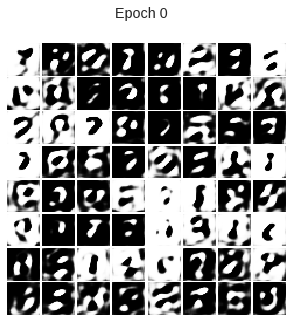

Epoch 1 batch 100 fake -0.157404571772 real -0.0862783640623 g 0.157310247421 d -0.0711262077093
Epoch 1 batch 200 fake -0.160384491086 real -0.0864877849817 g 0.160601332784 d -0.0738967061043
Epoch 1 batch 300 fake -0.168779745698 real -0.087288826704 g 0.169543832541 d -0.0814909189939
Epoch 1 batch 400 fake -0.176331549883 real -0.0878675654531 g 0.176027610898 d -0.0884639844298


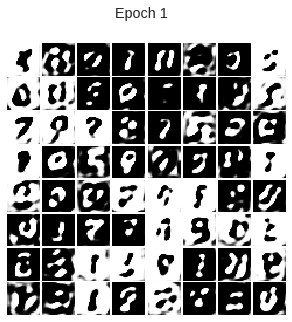

Epoch 2 batch 100 fake -0.211148798466 real -0.0824271962047 g 0.209820359945 d -0.128721602261
Epoch 2 batch 200 fake -0.21794064343 real -0.0811760947108 g 0.219302102923 d -0.136764548719
Epoch 2 batch 300 fake -0.227175861597 real -0.0813432633877 g 0.229125678539 d -0.145832598209
Epoch 2 batch 400 fake -0.235082998872 real -0.080477155745 g 0.237679228187 d -0.154605843127


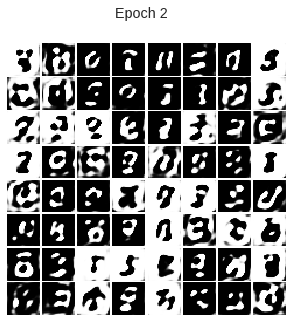

Epoch 3 batch 100 fake -0.277325361967 real -0.070042014122 g 0.276431977749 d -0.207283347845
Epoch 3 batch 200 fake -0.282620608807 real -0.0696240589023 g 0.284219056368 d -0.212996549904
Epoch 3 batch 300 fake -0.290754944086 real -0.0696939900517 g 0.291215717793 d -0.221060954034
Epoch 3 batch 400 fake -0.29685112834 real -0.0709770992398 g 0.298138290644 d -0.2258740291


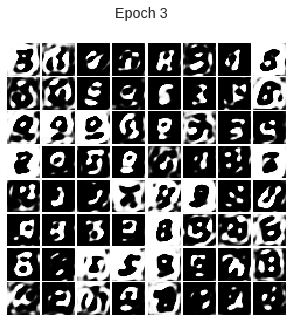

Epoch 4 batch 100 fake -0.32533660531 real -0.0609321072698 g 0.325124561787 d -0.264404498041
Epoch 4 batch 200 fake -0.325712293386 real -0.055068641901 g 0.329466611147 d -0.270643651485
Epoch 4 batch 300 fake -0.327073335648 real -0.049710676074 g 0.329886078835 d -0.277362659574
Epoch 4 batch 400 fake -0.328063547611 real -0.0410803705454 g 0.32960152626 d -0.286983177066


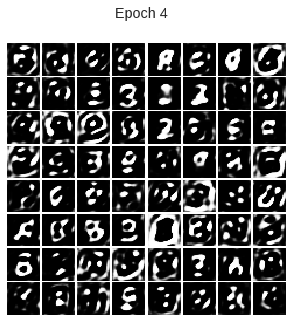

Epoch 5 batch 100 fake -0.330968827009 real 0.0383188650012 g 0.329653948545 d -0.36928769201
Epoch 5 batch 200 fake -0.326660066843 real 0.0414619147778 g 0.327254027128 d -0.368121981621
Epoch 5 batch 300 fake -0.324598938227 real 0.0405204892159 g 0.326602011919 d -0.365119427443
Epoch 5 batch 400 fake -0.324537992477 real 0.0433610640466 g 0.32632869482 d -0.367899056524


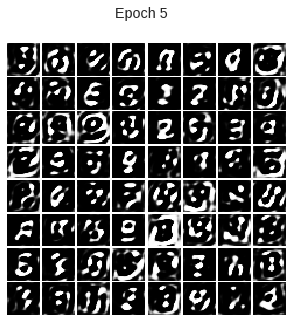

Epoch 6 batch 100 fake -0.320374131203 real 0.0535724200308 g 0.322380751371 d -0.373946551234
Epoch 6 batch 200 fake -0.317060887814 real 0.0465474762022 g 0.319999992847 d -0.363608364016
Epoch 6 batch 300 fake -0.316924542189 real 0.0388373509049 g 0.319555521011 d -0.355761893094
Epoch 6 batch 400 fake -0.313598394394 real 0.0319540947676 g 0.315791815519 d -0.345552489161


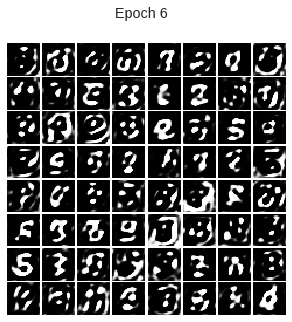

Epoch 7 batch 100 fake -0.303974837065 real 0.00165179756004 g 0.302079319954 d -0.305626634625
Epoch 7 batch 200 fake -0.299538999796 real 0.000106512612547 g 0.300849288702 d -0.299645512408
Epoch 7 batch 300 fake -0.300320148468 real -0.00303011666983 g 0.301659107208 d -0.297290031798
Epoch 7 batch 400 fake -0.298547059298 real -0.00692875962704 g 0.300287753344 d -0.291618299671


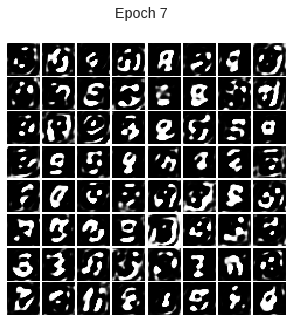

Epoch 8 batch 100 fake -0.288167506456 real -0.0220218952745 g 0.294416368008 d -0.266145611182
Epoch 8 batch 200 fake -0.288911342621 real -0.0207594875246 g 0.295308679342 d -0.268151855096
Epoch 8 batch 300 fake -0.291077882051 real -0.0209780689329 g 0.295958071947 d -0.270099813119
Epoch 8 batch 400 fake -0.291557073593 real -0.0216253809631 g 0.295241057873 d -0.26993169263


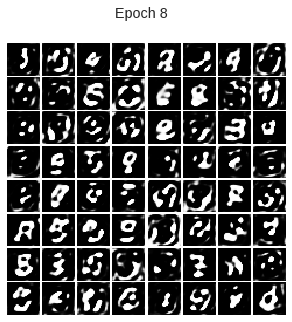

Epoch 9 batch 100 fake -0.288065433502 real -0.0230412054807 g 0.292609363794 d -0.265024228022
Epoch 9 batch 200 fake -0.287773281336 real -0.025222659111 g 0.292922884226 d -0.262550622225
Epoch 9 batch 300 fake -0.287426263094 real -0.0269568841904 g 0.291191518307 d -0.260469378904
Epoch 9 batch 400 fake -0.28735986352 real -0.0274293813854 g 0.292835116386 d -0.259930482134


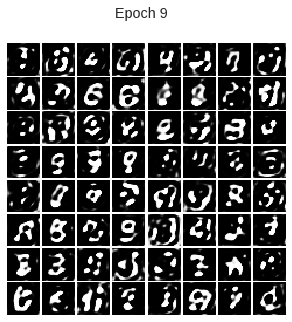

Epoch 10 batch 100 fake -0.279184788465 real -0.0318852551281 g 0.283043771982 d -0.247299533337
Epoch 10 batch 200 fake -0.279897272587 real -0.0299667473882 g 0.285637021065 d -0.249930525199
Epoch 10 batch 300 fake -0.280475199223 real -0.0305824372917 g 0.2836792171 d -0.249892761931
Epoch 10 batch 400 fake -0.281015098095 real -0.0287275910378 g 0.286439865828 d -0.252287507057


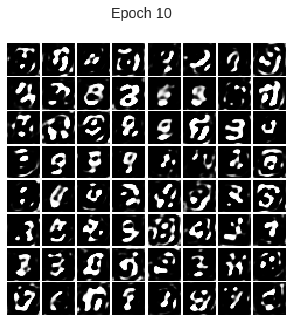

Epoch 11 batch 100 fake -0.268333107233 real -0.020047314465 g 0.272548913956 d -0.248285792768
Epoch 11 batch 200 fake -0.266223579645 real -0.0196658484638 g 0.270080924034 d -0.246557731181
Epoch 11 batch 300 fake -0.267177581787 real -0.0176599752158 g 0.270881891251 d -0.249517606571
Epoch 11 batch 400 fake -0.266894906759 real -0.0155122457072 g 0.27049022913 d -0.251382661052


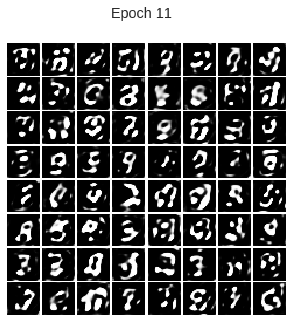

Epoch 12 batch 100 fake -0.25928735733 real 0.00145303609315 g 0.263680696487 d -0.260740393423
Epoch 12 batch 200 fake -0.260834485292 real 0.00357147445902 g 0.259324550629 d -0.264405959751
Epoch 12 batch 300 fake -0.262320369482 real 0.00497883418575 g 0.261375784874 d -0.267299203668
Epoch 12 batch 400 fake -0.261839538813 real 0.00700177531689 g 0.262082844973 d -0.26884131413


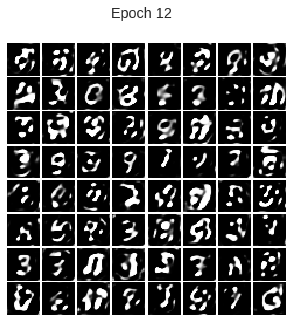

Epoch 13 batch 100 fake -0.246056050062 real 0.0181679017842 g 0.247144907713 d -0.264223951846
Epoch 13 batch 200 fake -0.25042361021 real 0.0208066161722 g 0.252540796995 d -0.271230226383
Epoch 13 batch 300 fake -0.252482056618 real 0.0219756346196 g 0.255309134722 d -0.274457691237
Epoch 13 batch 400 fake -0.254127681255 real 0.0243613068014 g 0.255726009607 d -0.278488988057


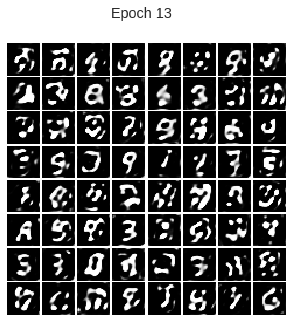

Epoch 14 batch 100 fake -0.247027650476 real 0.0424219034612 g 0.246625289321 d -0.289449553937
Epoch 14 batch 200 fake -0.252222597599 real 0.0468443036079 g 0.253148704767 d -0.299066901207
Epoch 14 batch 300 fake -0.254825741053 real 0.0480227731168 g 0.2563149333 d -0.302848514169
Epoch 14 batch 400 fake -0.255568236113 real 0.0503287650645 g 0.257609367371 d -0.305897001177


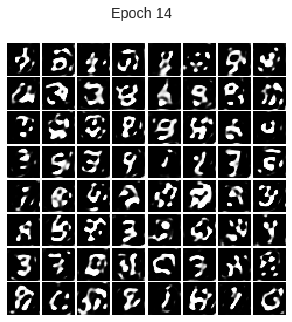

Epoch 15 batch 100 fake -0.247636064887 real 0.0576567314565 g 0.24367210269 d -0.305292796344
Epoch 15 batch 200 fake -0.241639077663 real 0.0551411770284 g 0.243871897459 d -0.296780254692
Epoch 15 batch 300 fake -0.240212470293 real 0.0557907409966 g 0.241925418377 d -0.29600321129
Epoch 15 batch 400 fake -0.238244503736 real 0.0565564259887 g 0.240083485842 d -0.294800929725


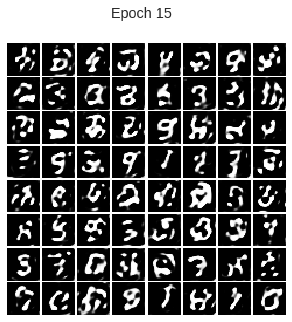

Epoch 16 batch 100 fake -0.211025118828 real 0.0560688078403 g 0.211168557405 d -0.267093926668
Epoch 16 batch 200 fake -0.208260193467 real 0.0572296828032 g 0.207611501217 d -0.26548987627
Epoch 16 batch 300 fake -0.206408649683 real 0.0574201159179 g 0.208138555288 d -0.263828765601
Epoch 16 batch 400 fake -0.203005686402 real 0.0575035065413 g 0.204460993409 d -0.260509192944


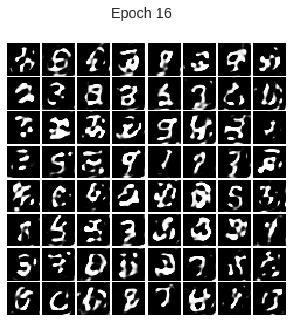

Epoch 17 batch 100 fake -0.178512871265 real 0.0632429942489 g 0.178073003888 d -0.241755865514
Epoch 17 batch 200 fake -0.17533929646 real 0.0636199042201 g 0.176521733403 d -0.23895920068
Epoch 17 batch 300 fake -0.175620064139 real 0.0664615035057 g 0.17511497438 d -0.242081567645
Epoch 17 batch 400 fake -0.17570130527 real 0.0679221227765 g 0.175417035818 d -0.243623428047


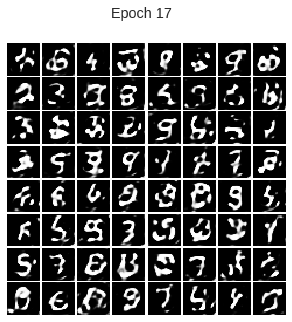

Epoch 18 batch 100 fake -0.17221724987 real 0.0796737372875 g 0.174668446183 d -0.251890987158
Epoch 18 batch 200 fake -0.171085417271 real 0.081851169467 g 0.171568766236 d -0.252936586738
Epoch 18 batch 300 fake -0.170224145055 real 0.0827142670751 g 0.172120124102 d -0.25293841213
Epoch 18 batch 400 fake -0.169390588999 real 0.0832429155707 g 0.170714989305 d -0.25263350457


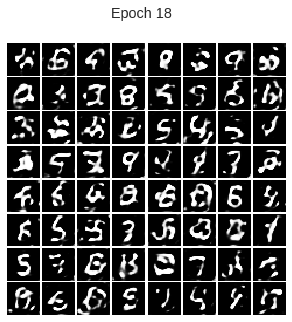

Epoch 19 batch 100 fake -0.172584205866 real 0.0923263803124 g 0.168087944388 d -0.264910586178
Epoch 19 batch 200 fake -0.170273959637 real 0.0934044867754 g 0.169768765569 d -0.263678446412
Epoch 19 batch 300 fake -0.168327718973 real 0.0926487669349 g 0.168597087264 d -0.260976485908
Epoch 19 batch 400 fake -0.168200716376 real 0.0937156751752 g 0.169323787093 d -0.261916391551


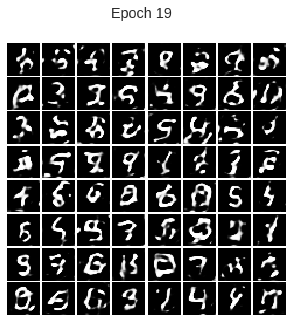

Epoch 20 batch 100 fake -0.175765424967 real 0.10583461076 g 0.179732188582 d -0.281600035727
Epoch 20 batch 200 fake -0.170562446117 real 0.102460972965 g 0.171549618244 d -0.273023419082
Epoch 20 batch 300 fake -0.17090241611 real 0.10287220031 g 0.171777054667 d -0.27377461642
Epoch 20 batch 400 fake -0.170521005988 real 0.102919593453 g 0.171527415514 d -0.273440599442


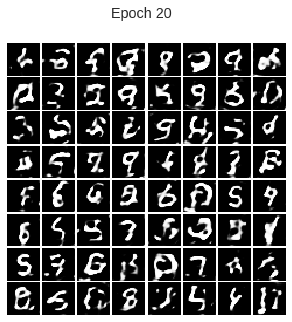

Epoch 21 batch 100 fake -0.170703083277 real 0.104495339096 g 0.169847935438 d -0.275198422372
Epoch 21 batch 200 fake -0.167260676622 real 0.103612072766 g 0.16626213491 d -0.270872749388
Epoch 21 batch 300 fake -0.167842373252 real 0.10500895232 g 0.167946726084 d -0.272851325572
Epoch 21 batch 400 fake -0.169471696019 real 0.106529198587 g 0.170025274158 d -0.276000894606


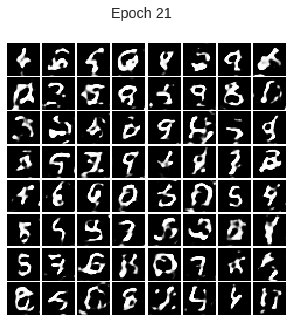

Epoch 22 batch 100 fake -0.163041576743 real 0.102673791349 g 0.164642438293 d -0.265715368092
Epoch 22 batch 200 fake -0.159333154559 real 0.101465642452 g 0.162056848407 d -0.260798797011
Epoch 22 batch 300 fake -0.162431895733 real 0.104564517736 g 0.163223698735 d -0.266996413469
Epoch 22 batch 400 fake -0.164399772882 real 0.106922693551 g 0.165535286069 d -0.271322466433


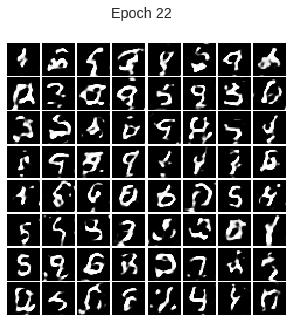

Epoch 23 batch 100 fake -0.158187136054 real 0.102832980454 g 0.157577008009 d -0.261020116508
Epoch 23 batch 200 fake -0.154958546162 real 0.100981146097 g 0.156075596809 d -0.255939692259
Epoch 23 batch 300 fake -0.153986990452 real 0.100742630661 g 0.153983771801 d -0.254729621112
Epoch 23 batch 400 fake -0.154469147325 real 0.101338490844 g 0.154745146632 d -0.255807638168


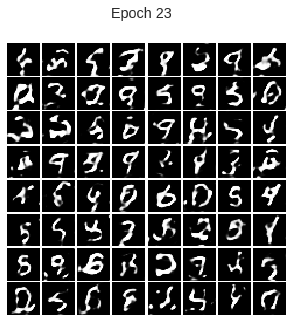

Epoch 24 batch 100 fake -0.155591115355 real 0.103326737881 g 0.154448658228 d -0.258917853236
Epoch 24 batch 200 fake -0.152346253395 real 0.102664276958 g 0.150857016444 d -0.255010530353
Epoch 24 batch 300 fake -0.151914834976 real 0.102209679782 g 0.151058554649 d -0.254124514759
Epoch 24 batch 400 fake -0.151129111648 real 0.101627454162 g 0.150794669986 d -0.252756565809


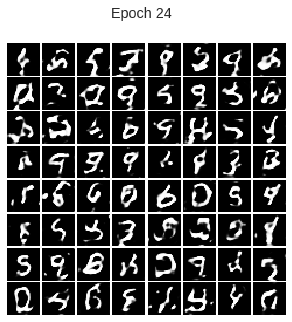

Epoch 25 batch 100 fake -0.146331652999 real 0.0977447330952 g 0.145417526364 d -0.244076386094
Epoch 25 batch 200 fake -0.139022216201 real 0.0929498448968 g 0.138623893261 d -0.231972061098
Epoch 25 batch 300 fake -0.139944970608 real 0.0937839969993 g 0.139915436506 d -0.233728967607
Epoch 25 batch 400 fake -0.140626221895 real 0.0941321253777 g 0.141149714589 d -0.234758347273


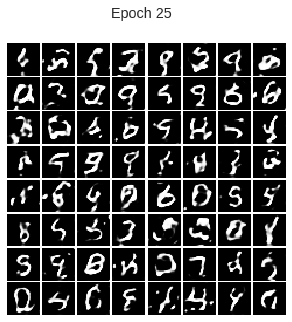

Epoch 26 batch 100 fake -0.143393948674 real 0.0965965762734 g 0.144305154681 d -0.239990524948
Epoch 26 batch 200 fake -0.137657672167 real 0.0934720858932 g 0.138638913631 d -0.23112975806
Epoch 26 batch 300 fake -0.135352447629 real 0.0920244604349 g 0.136792764068 d -0.227376908064
Epoch 26 batch 400 fake -0.13469773531 real 0.0915096253157 g 0.135930359364 d -0.226207360625


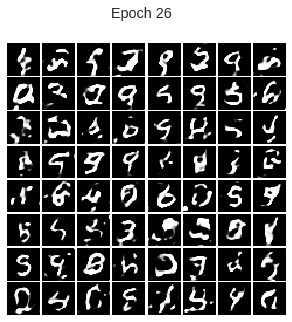

Epoch 27 batch 100 fake -0.136602237821 real 0.0957343578339 g 0.136981636286 d -0.232336595654
Epoch 27 batch 200 fake -0.131790235639 real 0.0923207849264 g 0.133514180779 d -0.224111020565
Epoch 27 batch 300 fake -0.130914732814 real 0.0919631272554 g 0.132415875793 d -0.222877860069
Epoch 27 batch 400 fake -0.1308606565 real 0.0921431556344 g 0.132614761591 d -0.223003812134


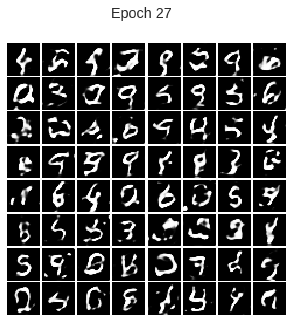

Epoch 28 batch 100 fake -0.137465119362 real 0.0973451882601 g 0.139209166169 d -0.234810307622
Epoch 28 batch 200 fake -0.132309049368 real 0.0928752794862 g 0.133814066648 d -0.225184328854
Epoch 28 batch 300 fake -0.131329655647 real 0.0926429256797 g 0.13329783082 d -0.223972581327
Epoch 28 batch 400 fake -0.131004869938 real 0.0922699943185 g 0.132002964616 d -0.223274864256


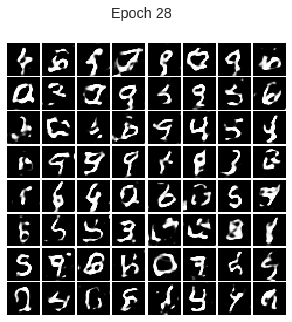

Epoch 29 batch 100 fake -0.13192795217 real 0.0939986631274 g 0.133418723941 d -0.225926615298
Epoch 29 batch 200 fake -0.128092557192 real 0.0918080508709 g 0.129677951336 d -0.219900608063
Epoch 29 batch 300 fake -0.128242492676 real 0.0918399989605 g 0.129881665111 d -0.220082491636
Epoch 29 batch 400 fake -0.127913534641 real 0.0911714434624 g 0.129864156246 d -0.219084978104


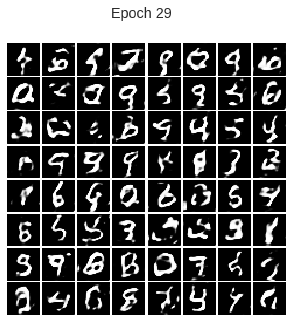

In [17]:
for epoch in range(30):
    epoch_real_loss = []
    epoch_fake_loss = []
    epoch_g_loss = []
    
    for i, real_image in enumerate(mnist_generator()):
        step = epoch * step_per_epoch + i

        
        # 训练D识别G生成的图片为假图片
        r_fake = exe.run(train_d_fake, fetch_list=[fake_loss], feed={
            'z': np.array(next(z_generator))
        })
        clip_weight(fluid.global_scope(), d_params)
        epoch_fake_loss.append(np.mean(r_fake))
        
        # 训练D识别真实图片
        r_real = exe.run(train_d_real, fetch_list=[real_loss], feed={
            'img': np.array(real_image)
        })
        clip_weight(fluid.global_scope(), d_params)
        epoch_real_loss.append(np.mean(r_real))
        
        if i % 5 == 0:
          ## 训练G生成符合D标准的“真实”图片
          r_g = exe.run(train_g, fetch_list=[g_loss], feed={
              'z': np.array(next(z_generator))
          })
          epoch_g_loss.append(np.mean(r_g))
        
        if i > 0 and i % 100 == 0:
            print("Epoch {} batch {} fake {} real {} g {} d {}".format(
                epoch, i, np.mean(epoch_fake_loss), np.mean(epoch_real_loss), np.mean(epoch_g_loss),
                -1 * np.mean(epoch_real_loss) + np.mean(epoch_fake_loss)
            ))
        
    # 测试
    r_i = exe.run(infer_program, fetch_list=[fake], feed={
        'z': test_z
    })
    show_image_grid(r_i[0], epoch)